In [267]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [268]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [278]:
# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 3
num_classes = 10
batch_size = 100
num_epochs = 30
learning_rate = 0.01

In [270]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [279]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional = True, dropout = 0.1)
        self.fc = nn.Linear(2 * hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [280]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas = (0.94,0.95))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 1, factor = 0.5)

In [281]:
# Train the model
train_loss = np.zeros(num_epochs)
test_acc = np.zeros(num_epochs)

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss[epoch] += loss.item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc[epoch] = 100 * correct/total
        scheduler.step(criterion(outputs, labels))
        print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))     
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Test Accuracy of the model on the 10000 test images: 95.56 %
Epoch [1/30], Step [600/600], Loss: 0.2368
Test Accuracy of the model on the 10000 test images: 95.57 %
Epoch [2/30], Step [600/600], Loss: 0.1709
Test Accuracy of the model on the 10000 test images: 93.8 %
Epoch [3/30], Step [600/600], Loss: 0.2413
Test Accuracy of the model on the 10000 test images: 95.98 %
Epoch [4/30], Step [600/600], Loss: 0.1228
Test Accuracy of the model on the 10000 test images: 96.12 %
Epoch [5/30], Step [600/600], Loss: 0.1076
Test Accuracy of the model on the 10000 test images: 97.33 %
Epoch [6/30], Step [600/600], Loss: 0.0526
Test Accuracy of the model on the 10000 test images: 97.57 %
Epoch [7/30], Step [600/600], Loss: 0.0753
Test Accuracy of the model on the 10000 test images: 97.92 %
Epoch [8/30], Step [600/600], Loss: 0.0326
Test Accuracy of the model on the 10000 test images: 98.02 %
Epoch [9/30], Step [600/600], Loss: 0.0379
Test Accuracy of the model on the 10000 test images: 98.29 %
Epoc

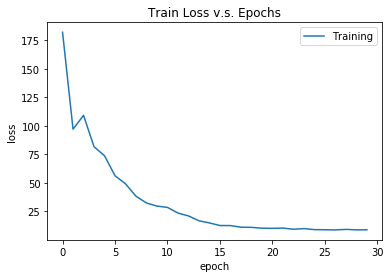

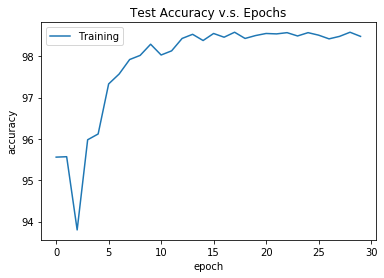

In [282]:
# Test the model
plt.plot(train_loss,markerfacecolor='blue',label="Training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train Loss v.s. Epochs")
plt.legend()
plt.show()
plt.plot(test_acc,markerfacecolor='blue',label="Training")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Test Accuracy v.s. Epochs")
plt.legend()
plt.show()

In [79]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')